# Predicting probability of default 

In [186]:
# Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, roc_curve, roc_auc_score


## Load cleaned data

In [188]:
# Load cleaned dataset
cleaned_loan_data = pd.read_csv('./data/clean_loan_data.csv')

if 'Unnamed: 0' in cleaned_loan_data.columns:
    cleaned_loan_data.drop(columns='Unnamed: 0',inplace= True)
else:
    pass


In [189]:
# Create the X and y data sets
X = cleaned_loan_data.drop(columns= 'loan_status').copy()
y = cleaned_loan_data[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

In [190]:
def preprocess_data(df):

    """ One hot encode non-numerical columns """

    # Create two data sets for numeric and non-numeric data
    num_df = df.select_dtypes(exclude=['object'])
    str_df = df.select_dtypes(include=['object'])

    # One-hot encode the non-numeric columns
    str_onehot = pd.get_dummies(str_df)

    prepared_df = pd.concat([num_df, str_onehot], axis=1)

    return prepared_df


In [191]:
# Preprocess train and test data
X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)

In [192]:
print(list(X_train.columns))

['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_N', 'cb_person_default_on_file_Y']


# Multivariate Logistic Regression (with different thresholds)

In [200]:
# Train the logistic regression model on the training data
clf_lr = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Create predictions of probability for loan status using test data
preds_lr = clf_lr.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
preds_df_lr = pd.DataFrame(preds_lr[:,1], columns = ['prob_default'])

# Reassign loan status based on 0.5 threshold
preds_df_lr['loan_status_t1'] = preds_df_lr['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Reassign the values of loan status based on 0.4 threshold
preds_df_lr['loan_status_t2'] = preds_df_lr['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)


In [201]:

# Evaluate recall
# Print the classification report 
target_names = ['Non-Default', 'Default']
print('Logistic regression with 0.5 threshold:\n',
      classification_report(y_test, preds_df_lr['loan_status_t1'], target_names=target_names))


# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_lr['loan_status_t2'], target_names=target_names))

Accuracy: 0.8020532835567623
Logistic regression with 0.5 threshold:
               precision    recall  f1-score   support

 Non-Default       0.81      0.98      0.89      9194
     Default       0.73      0.16      0.26      2592

    accuracy                           0.80     11786
   macro avg       0.77      0.57      0.57     11786
weighted avg       0.79      0.80      0.75     11786

              precision    recall  f1-score   support

 Non-Default       0.86      0.92      0.89      9194
     Default       0.62      0.45      0.52      2592

    accuracy                           0.82     11786
   macro avg       0.74      0.69      0.71     11786
weighted avg       0.80      0.82      0.81     11786



The Logistic Regression model with 0.4 threshold has a higher default recall than 0.5 model. The accuracy of the model with 0.4 threshold is higher. 

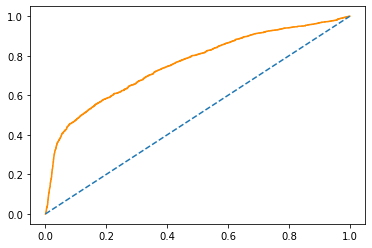

Area under Curve for Logistic regression model: 0.7568318173151034


In [203]:
# Plot the ROC curve of the probabilities of default
prob_default = preds_lr[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test,prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test,prob_default)
print('Area under Curve for Logistic regression model:',auc)

## XGBoost

In [240]:
from pandas import MultiIndex, Int16Dtype
import xgboost as xgb

In [243]:
# Train a model

clf_gbt = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder= False,eval_metric = 'auc').fit(X_train, np.ravel(y_train))

# Predict the labels for loan status
gbt_preds = clf_gbt.predict(X_test)

In [244]:
# Print the feature importances from the model
print(pd.DataFrame(clf_gbt.get_booster().get_score(importance_type = 'weight').items(), columns = ['feature','importance']).sort_values(by = ['importance'],ascending = False))

                           feature  importance
1                    person_income       787.0
4                    loan_int_rate       516.0
3                        loan_amnt       344.0
0                       person_age       286.0
2                person_emp_length       279.0
5              loan_percent_income       263.0
6       cb_person_cred_hist_length       159.0
14             loan_intent_MEDICAL        90.0
11   loan_intent_DEBTCONSOLIDATION        64.0
10      person_home_ownership_RENT        61.0
7   person_home_ownership_MORTGAGE        54.0
19                    loan_grade_C        51.0
15            loan_intent_PERSONAL        49.0
20                    loan_grade_D        47.0
9        person_home_ownership_OWN        42.0
16             loan_intent_VENTURE        38.0
12           loan_intent_EDUCATION        37.0
13     loan_intent_HOMEIMPROVEMENT        34.0
21                    loan_grade_E        28.0
24     cb_person_default_on_file_N        28.0
18           

### Analyse Feature importance 

## Select XGB model with different features 

In [211]:
# Use test_train_split to create the training and test sets
X2 = cleaned_loan_data[['loan_int_rate','person_emp_length']]
X3 = cleaned_loan_data[['person_income','loan_int_rate','loan_percent_income']]

X2_train, X2_test = train_test_split(X2, test_size = .4, random_state = 123)
X3_train, X3_test = train_test_split(X3, test_size = .4, random_state = 123)


/opt/miniconda3/envs/nishaal-dd/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


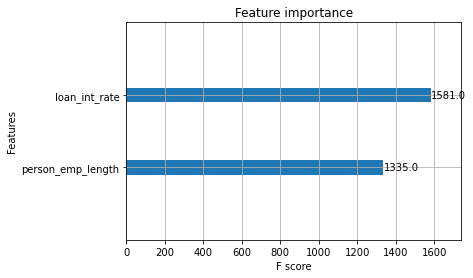

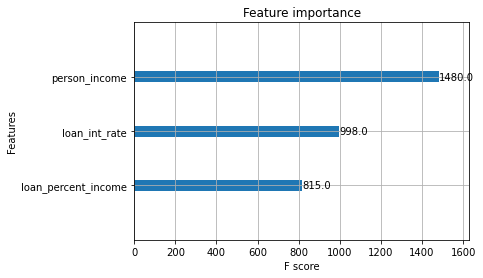

In [212]:
# Train a model on the X data with 2 columns
clf_gbt2 = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder= False,eval_metric = 'auc').fit(X2_train, np.ravel(y_train))
clf_gbt3 = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder= False,eval_metric = 'auc').fit(X3_train, np.ravel(y_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt2, importance_type = 'weight')
xgb.plot_importance(clf_gbt3, importance_type = 'weight')
plt.show()

In [213]:
# Predict the loan_status using each model
gbt2_preds = clf_gbt2.predict(X2_test)
gbt3_preds = clf_gbt3.predict(X3_test)

# XBG with Cross Validation Approach

In [215]:
# Set the values for number of folds and stopping iterations
n_folds = 5
early_stopping = 10

# Set parameters
params = {'objective': 'binary:logistic', 'seed': 123, 'eval_metric':'auc'}
# Create the DTrain matrix for XGBoost
DTrain = xgb.DMatrix(X_train, label = y_train)

# Create the data frame of cross validations
cv_df = xgb.cv(params, DTrain, num_boost_round = 5, nfold=n_folds,
            early_stopping_rounds=early_stopping)


/opt/miniconda3/envs/nishaal-dd/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.895947       0.002251       0.891604      0.009428
1        0.902931       0.003206       0.897648      0.008133
2        0.911380       0.001820       0.905553      0.007240
3        0.915385       0.000750       0.908138      0.008153
4        0.920330       0.001100       0.912328      0.006981


In [216]:
cv_results_big = xgb.cv(params, DTrain, num_boost_round = 600, nfold=10,
            shuffle = True)

0.9433009558333313


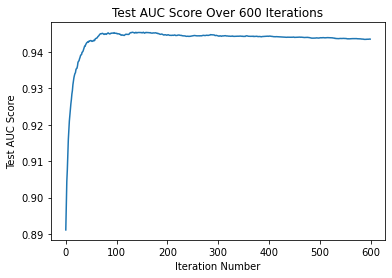

In [217]:
# Calculate the mean of the test AUC scores
print(np.mean(cv_results_big['test-auc-mean']))

# Plot the test AUC scores for each iteration
plt.plot(cv_results_big['test-auc-mean'])
plt.title('Test AUC Score Over 600 Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Test AUC Score')
plt.show()

In [246]:
from sklearn.model_selection import cross_val_score
# from pandas import MultiIndex, Int16Dtype
# Create a gradient boosted tree model using two hyperparameters
gbt = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 7, use_label_encoder=False, eval_metric = 'auc')

# Calculate the cross validation scores for 4 folds
cv_scores = cross_val_score(gbt, X_train, np.ravel(y_train), cv = 4)

# Print the cross validation scores
print(cv_scores)

# Print the average accuracy and standard deviation of the scores
print("Average accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

/opt/miniconda3/envs/nishaal-dd/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/miniconda3/envs/nishaal-dd/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/miniconda3/envs/nishaal-dd/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/miniconda3/envs/nishaal-dd/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pan

[0.93574661 0.92986425 0.93506787 0.92984838]
Average accuracy: 0.93 (+/- 0.01)


In [247]:
# Undersampling
# Concat the training sets
X_y_train = pd.concat([X_train.reset_index(drop=True),
                       y_train.reset_index(drop=True)],axis =1 )
# Get the counts of defaults and non_defaults
count_nondefault, count_default = X_y_train['loan_status'].value_counts()

# Separate nondefaults and defaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults  = X_y_train[X_y_train['loan_status'] == 1]


In [248]:
# Undersample the non-defaults 
nondefaults_under = nondefaults.sample(count_default)

# Concat the undersample non-defaults witht the defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop=True), 
                            defaults.reset_index(drop = True)], axis = 0)

X_train_under = X_y_train_under.drop(columns= 'loan_status').copy()
y_train_under =  X_y_train_under[['loan_status']]


clf_gbt_under = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder= False,eval_metric = 'auc').fit(X_train_under, np.ravel(y_train_under))



/opt/miniconda3/envs/nishaal-dd/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [169]:
target_names = ['Non-Default', 'Default']
print(classification_report(y_test,gbt_preds, target_names=target_names))
print(classification_report(y_test, gbt_under_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9194
     Default       0.96      0.74      0.84      2592

    accuracy                           0.94     11786
   macro avg       0.94      0.87      0.90     11786
weighted avg       0.94      0.94      0.93     11786

              precision    recall  f1-score   support

 Non-Default       0.95      0.92      0.93      9194
     Default       0.74      0.82      0.78      2592

    accuracy                           0.90     11786
   macro avg       0.84      0.87      0.86     11786
weighted avg       0.90      0.90      0.90     11786



Macro average of F1 score - get good understanding of each models performance across defaults and non-defaults

ROC charts - line for each model to compare the lift 
AUC score - higher AUC better lift 

Model Calibration - probabilities should accurately represent the model's confidence level 


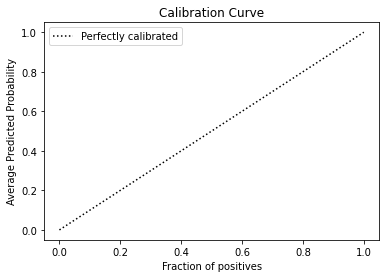

In [171]:
from sklearn.calibration import calibration_curve
calibration_curve(y_test,lr_proba, n_bins = 5)


# Add the calibration curve for the gradient boosted tree
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr,
         's-', label='%s' % 'Logistic Regression')
plt.plot(mean_pred_val_gbt, frac_of_pos_gbt,
         's-', label='%s' % 'Gradient Boosted tree')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

In [ ]:
# Print the logistic regression classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_lr['loan_status'], target_names=target_names))

# Print the gradient boosted tree classification report
print(classification_report(y_test, preds_df_gbt['loan_status'], target_names=target_names))

# Print the default F-1 scores for the logistic regression
print(precision_recall_fscore_support(y_test,preds_df_lr['loan_status'], average = 'macro')[2])

# Print the default F-1 scores for the gradient boosted tree
print(precision_recall_fscore_support(y_test,preds_df_gbt['loan_status'], average = 'macro')[2])

In [ ]:
# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, clf_logistic_preds)
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, clf_gbt_preds)

# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [ ]:
# Print the accuracy score of Logistic Regression model
print('Accuracy:',clf_lr.score(X_test,y_test))
